<a href="https://colab.research.google.com/github/netgvarun2021/Blackbox/blob/main/TextifyProofReading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import os
import pandas as pd
import spacy
from spacy import displacy
import nltk
from nltk.tokenize import word_tokenize
from google.colab import drive
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [5]:
imdb_dir = '/content/gdrive/MyDrive'
dataset_dir = os.path.join(imdb_dir, 'Textify.ai/Textify AI Text Corpus Center (Responses).xlsx')
#dataset_dir = os.path.join(imdb_dir, 'Textify.ai/training_set_rel3.xls')
print(dataset_dir)

/content/gdrive/MyDrive/Textify.ai/Textify AI Text Corpus Center (Responses).xlsx


In [6]:
df = pd.read_excel(dataset_dir)

In [7]:
df.shape

(734, 11)

In [8]:
df.head()

,Timestamp,Contributor,Topic,Writing Style,Essay Text,Essay Grading,University Name,Education Program,Relevant Field (Major/ Subject of study etc),Reference Link,Comments (is something unusual about the essay?)
0,2021-06-20 05:36:05.410,Tin,Bacon,Narrative,"THE ALARM CLOCK IS, TO MANY high school studen...",Average (B-C),Duke University,Bachelors,NaN,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
1,2021-06-20 05:47:07.236,Tin,“Beyond Plug-and-Chug Math”,Persuasive,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,Average (B-C),MIT - Massachusetts Institute of Technology,Bachelors,Mathematics,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
2,2021-06-20 06:00:53.430,Tin,“A Different Kind of love”,"Narrative, Personal","WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",Excellent (A+),Stanford University,Bachelors,Spanish Language,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
3,2021-06-20 06:12:52.684,Tin,“From Flaubert to Frisbee”,Persuasive,"THIS SUMMER, I WENT TO THE governor’s Honors P...",Average (B-C),Brown University,Masters,Literature,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN
4,2021-06-20 06:20:05.473,Tin,Raising the Bar,Narrative,THIS PAST SUMMER I HAD THE opportunity to part...,Average (B-C),NaN,Masters,Engineering and Sciences,http://www.qianmu.org/u/lystu/school/file/0hme...,NaN


In [9]:
# df['domain1_score'].value_counts()
# df.rename(columns = {'essay':'Essay Text'}, inplace = True)
# df.rename(columns = {'domain1_score':'Essay Grading'}, inplace = True)


In [10]:
nlp = spacy.load('en_core_web_sm')


In [11]:
df[:1]['Essay Text'].values[0]

'THE ALARM CLOCK IS, TO MANY high school students, a wailing monstrosity whose purpose is to torture all who are sleep-deprived. Those who believe this are misguided, and are simply viewing the situation from a twisted perspective. For when these imprudent early-risers blearily rub their eyes each morning, and search in vain for whatever is making that earsplitting noise, they are, without a doubt, annoyed. Why? \nIt isn’t because the only thing they desire is to sleep a few extra hours, as many would presume. no, these kids are groggy and irritable because they are waking up to what they think will be another horribly boring day of school. If one of these foolish Sallys or Joes were, say, sleeping comfortably on a Saturday morning, I could certainly see something different happening. A beautiful breakfast of tantalizing vittles—eggs, hash browns, and the like—would be ready and waiting for them on their kitchen tables. But the scrumptious delight to outshine them all would be a slab o

In [12]:
#df_essays_recovery = df_essays.copy()
df_essays = df['Essay Text'].to_frame()

In [13]:
df_essays.head()

,Essay Text
0,"THE ALARM CLOCK IS, TO MANY high school studen..."
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ..."
3,"THIS SUMMER, I WENT TO THE governor’s Honors P..."
4,THIS PAST SUMMER I HAD THE opportunity to part...


# **FEATURE EXTRACTION FROM ESSAY'S ASCII TEST**

## **COUNTING SENTENCES**

In [14]:
def count_sentences(essay):
  doc = nlp(essay)
  doc_sents = [sent for sent in doc.sents]
  return len(doc_sents)


In [15]:
str = '“I wanna go home!” I say as I sit on the kitchen floor watching my mother cook. “What do you mean?” she asks, giving me a questioning look. “Ethiopia?” “I don’t know.” Home. For most people, the word can be easily defined as the place where they grew up or live now. By that definition, the house in which I have lived for the past seven years would be my home. The problem is, I often find myself saying, “I wanna go home,” while sitting in that very house. The other candidate is the place where I grew up, but that could be either of two places: my home country of Ethiopia or my adopted hometown of Westbrook, Maine. I cannot choose one over the other. For better or for worse, each has shaped the person I am today more than can be expressed in words. Ethiopia is the place where I experienced so many of my “firsts.” Maine is the place where I developed my individuality. At the same time, neither can truly be my home. Though Ethiopia was my home at one point, it is no longer the same place I knew as a child because I am no longer that child. I can no longer relate to the culture the way I once did. As my sister often tells me, I have become “Americanized.” On the other hand, I have never felt at home in Maine. The first memory I have of Maine is my first day visiting Reiche Elementary, the school I would be attending. I stood in front of a group of seven- and eight-year-old boys and girls. Every face was pointed at me, every pair of eyes wide and expectant. I grabbed the fabric of my mother’s skirt and buried my face into the side of her leg. These children were all so different. Every child had a skin color different from mine. Though I picked out a few familiar words, I could not understand what they were saying. I knew I didn’t belong there, but there was no chance of hopping on a plane and going back to Ethiopia. I knew that, and the thought terrified me. I had never felt as uncomfortable and uncertain as I did that day. That day has stayed with me, along with the discomfort and uncertainty. Though the intensity of those feelings has faded, it has not gone away, and it is not likely to leave me soon. I cannot deny, however, that the environment Maine has provided has shaped me profoundly. Living in Maine has made me who I am today just as much as being born and raised in Ethiopia. Ethiopia gave me my cultural and family identity. Ethiopia is the place that comes to mind when I think of my family, since my entire extended family remains there. It is also the place that comes to mind when I think of my motivation, since I was raised in a culture that taught me to give one hundred percent at all times. Yet, the fact remains that I have lived in Maine for nearly ten years of my life. This environment has influenced me more than even I can comprehend. So, the question becomes: which of these places (if either) should I consider my home? In all honesty, I cannot choose one physical place and give it the title of “home.” Instead, I elect to compose my own definition of home, a definition that does not force me to choose between the two places in which I grew up. My definition allows me to think of home as a place in my mind, a state of mind that enables me to remember my childhood years in Ethiopia and the opportunities given to me by living in the U.S. It has taken a long time to define what home means to me — and even longer to find it — but doing so has given me an amazing sense of hope and comfort. In my mind, it is a place where I can escape. It is a place from which I draw strength when life gets too hectic or when I am faced with challenges that seem too great to overcome. It is what I really mean — what I have always meant — when I say that I want to go home.'
count_sentences(str)

48

In [16]:
df_essays['SentenceCount'] = df_essays['Essay Text'].apply(count_sentences)

In [17]:
df_essays[:10]

,Essay Text,SentenceCount
0,"THE ALARM CLOCK IS, TO MANY high school studen...",35
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,28
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",40
3,"THIS SUMMER, I WENT TO THE governor’s Honors P...",20
4,THIS PAST SUMMER I HAD THE opportunity to part...,23
5,"My eyes widen. “It’s all Greek to me,” I whisp...",46
6,"I could still hear her words, the words my tea...",31
7,It was a wet and dreary October evening. I sho...,30
8,"Oreos. On the exterior, a firm chocolate crust...",43
9,"Whether I was blowing out candles, writing a l...",21


In [18]:
df_essays.iloc[700].values[0]

'“Jooooorrrrddddannnnn,” my mom screamed with utter fear and panic in her voice. Surprisingly, amongst all of the chaos, her voice was all that I heard. I’m not sure if I was disoriented, bewildered or just in complete shock but at that particular moment, I felt nothing. That feeling of nothingness lasted 2.5 seconds because then the excruciating pain began. My knee felt as if someone had hit me with a Mack truck going 90 miles per hour. For the first time in my life, I had experienced real pain. I was 10 years old and I shattered my knee.\nI have always been a well rounded student. My focus has always been on my school and everything that comes along with it, which included extra-curricular activities. I was an avid gymnast. I had been in gymnastics since I was 3 years old. My parents were both extremely athletic. My dad was an All-American college football player and my mom was a cheerleader, so it was only fitting that I participated in something athletically strenuous as well. They

## **COUNTING WORDS w/o STOP WORDS**

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
word_tokens = word_tokenize(df_essays.iloc[729].values[0])
stop_words = set(stopwords.words('english'))

In [22]:
def count_non_stop_words(essay):
  word_tokens = word_tokenize(essay)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return len(filtered_sentence)


In [23]:
df_essays['WordCount'] = df_essays['Essay Text'].apply(count_non_stop_words)

In [24]:
df_essays.head()

,Essay Text,SentenceCount,WordCount
0,"THE ALARM CLOCK IS, TO MANY high school studen...",35,462
1,I HAVE ALWAYS BEEN A MATH-SCIENCE girl. I sigh...,28,309
2,"WHEN I WAS FOUR YEARS OLD, I fell in love. It ...",40,532
3,"THIS SUMMER, I WENT TO THE governor’s Honors P...",20,308
4,THIS PAST SUMMER I HAD THE opportunity to part...,23,320


In [25]:
#df_essays_mini = df_essays[:1]

## **COUNTING PARTS OF SPEECH**

In [26]:
def count_feature(postag,essay,wordcount,roundval):
  doc=nlp(essay)
  pos_counts = doc.count_by(spacy.attrs.POS)
  for k,v in sorted(pos_counts.items()):
    if doc.vocab[k] == postag:
      return round(v/wordcount,roundval)

# def count_verb(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'VERB':
#       return round(v/wordcount,0)

# def count_noun(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'NOUN':
#       return round(v/wordcount,0)

# def count_adjective(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'ADJ':
#       return round(v/wordcount,0)

# def count_adverb(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'ADV':
#       return round(v/wordcount,0)    

# def count_pronoun(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'PRON':
#       return round(v/wordcount,0)

# def count_punctuations(essay,wordcount):
#   doc=nlp(essay)
#   pos_counts = doc.count_by(spacy.attrs.POS)
#   for k,v in sorted(pos_counts.items()):
#     if doc.vocab[k] == 'PUNCT':
#       return round(v/wordcount,0)                        

In [27]:
df_essays['VerbCount']  = df_essays.apply(lambda x: count_feature('VERB',x['Essay Text'], 1,0), axis=1)
df_essays['NounCount']  = df_essays.apply(lambda x: count_feature('NOUN',x['Essay Text'], 1,0), axis=1)
df_essays['AdjCount']  = df_essays.apply(lambda x: count_feature('ADJ',x['Essay Text'], 1,0), axis=1)
df_essays['AdverbCount']  = df_essays.apply(lambda x: count_feature('ADV',x['Essay Text'], 1,0), axis=1)
df_essays['PronounCount']  = df_essays.apply(lambda x: count_feature('PRON',x['Essay Text'], 1,0), axis=1)
df_essays['PunctCount']  = df_essays.apply(lambda x: count_feature('PUNCT',x['Essay Text'], 1,0), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe62761c0d0>,
      dtype=object)

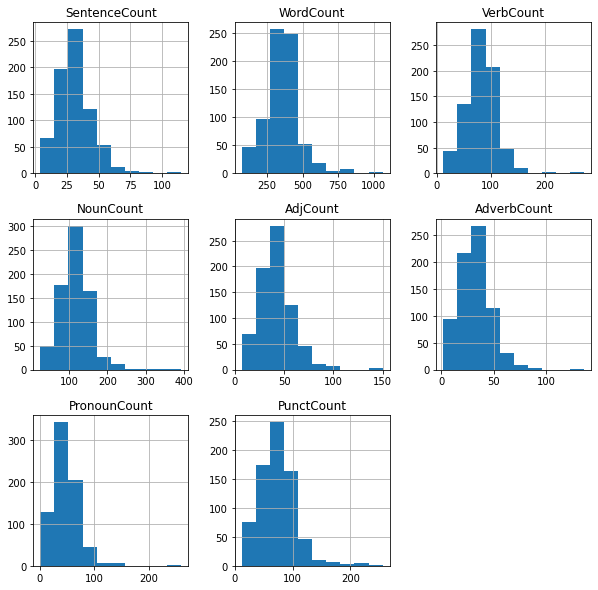

In [28]:
df_essays.hist(figsize=(10,10))

# Day 2

In [29]:
df_essays['Essay Grading'] = df['Essay Grading'] 

In [30]:
df_essays['Essay Grading'].value_counts()

Average (B-C)     401
Excellent (A+)    288
Bad (D-F)          45
Name: Essay Grading, dtype: int64

# **Normalizing the grades distribution by Feature Counts**

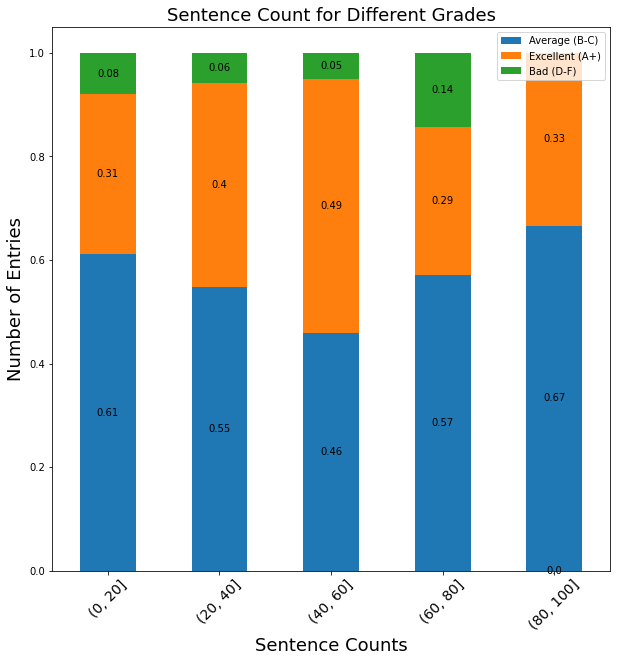

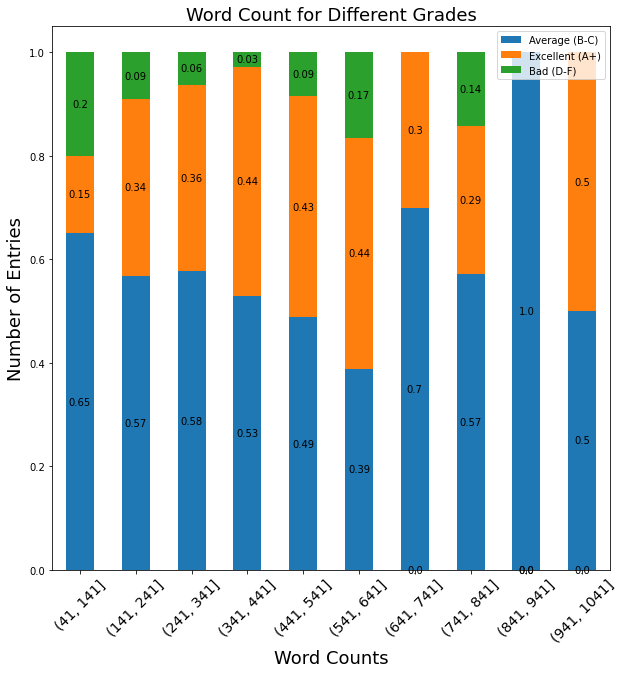

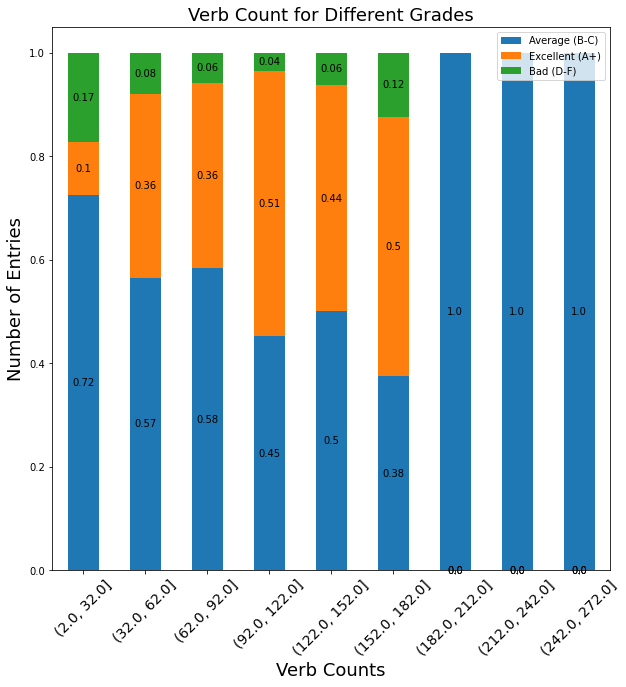

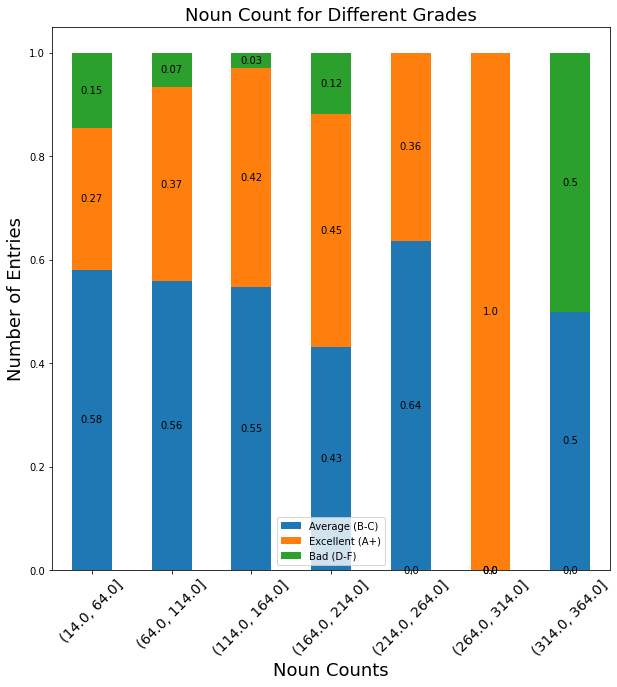

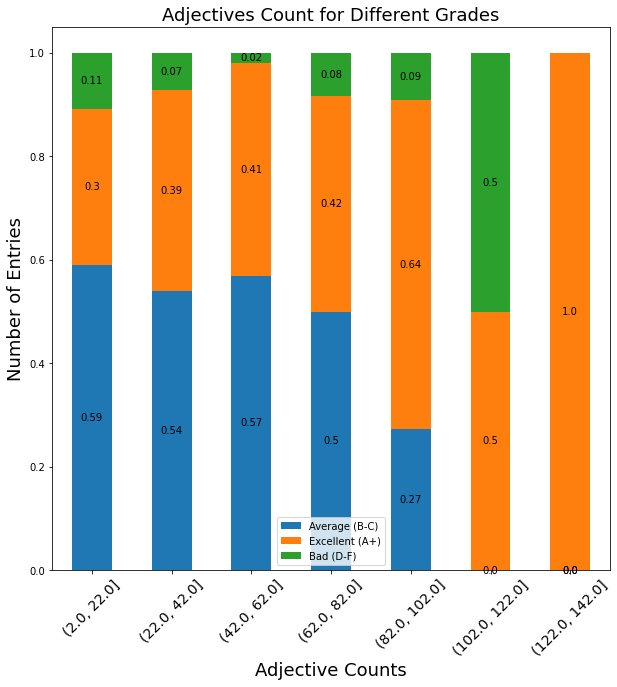

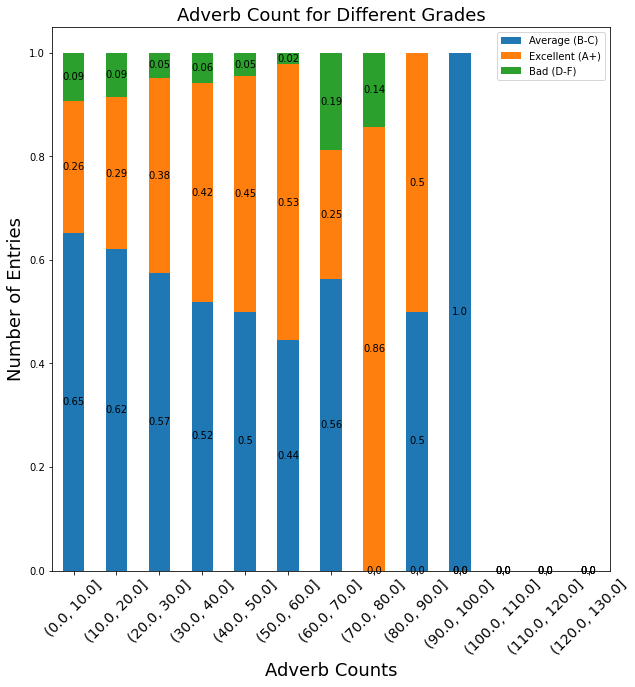

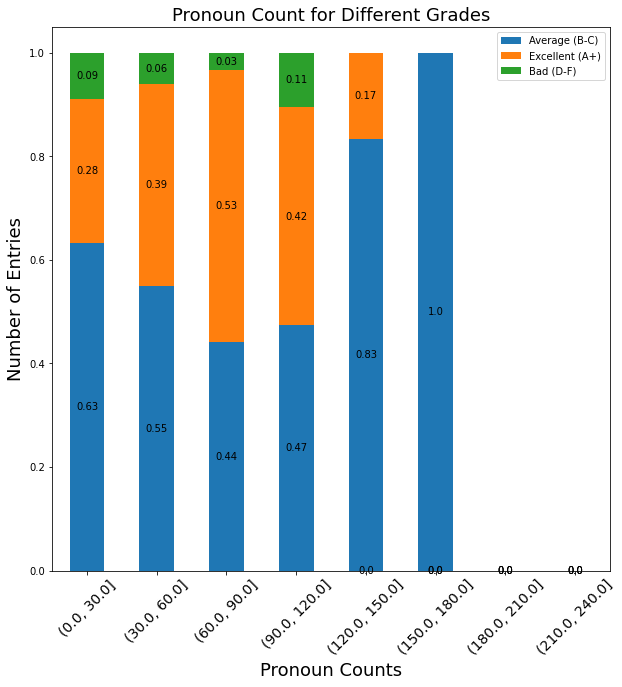

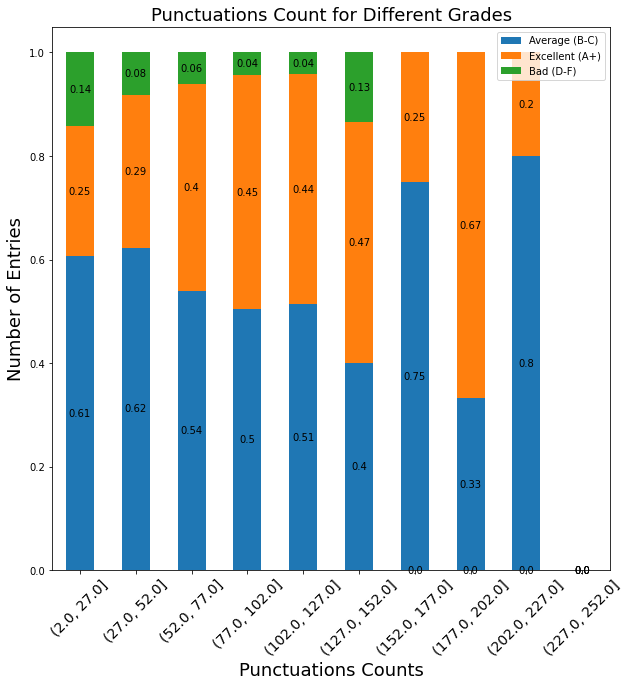

In [31]:
def display_stack_bar(col1,col2,title,xlabel,buffer,binsize):
  df_new = pd.DataFrame()
  bins_created = np.arange(min(df_essays[col1])-buffer, max(df_essays[col1]) + buffer, binsize) 
  df_essays[col2] = pd.cut(df_essays[col1], bins=bins_created)
  df_essays.sort_values(by = col1,inplace=True)
  counts = df_essays.groupby([col2,'Essay Grading'],sort=False).SentenceCount.count().unstack()
  df_essays.drop([col2], axis=1,inplace=True)
  counts.replace(np.nan,0,inplace=True)
  counts["sum"] = counts.sum(axis=1)
  df_new['Average (B-C)'] = counts['Average (B-C)']/counts['sum']
  df_new['Excellent (A+)'] = counts['Excellent (A+)']/counts['sum']
  df_new['Bad (D-F)'] = counts['Bad (D-F)']/counts['sum']
  ax = df_new.plot.bar(stacked=True,figsize=(10,10),width = 0.5)
  for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            round(height,2), 
            horizontalalignment='center', 
            verticalalignment='center')  
  plt.title(title,fontsize=18)
  plt.xlabel(xlabel,fontsize=18)
  plt.xticks(fontsize=14,rotation=45)
  plt.ylabel('Number of Entries',fontsize=18)
  plt.show()	

display_stack_bar('SentenceCount','SentenceCountCategory','Sentence Count for Different Grades','Sentence Counts',4,20)
display_stack_bar('WordCount','WordCountCategory','Word Count for Different Grades','Word Counts',30,100)
display_stack_bar('VerbCount','VerbCountCategory','Verb Count for Different Grades','Verb Counts',10,30)
display_stack_bar('NounCount','NounCountCategory','Noun Count for Different Grades','Noun Counts',10,50)
display_stack_bar('AdjCount','AdjectivesCountCategory','Adjectives Count for Different Grades','Adjective Counts',5,20)
display_stack_bar('AdverbCount','AdverbCountCategory','Adverb Count for Different Grades','Adverb Counts',2,10)
display_stack_bar('PronounCount','PronounCountCategory','Pronoun Count for Different Grades','Pronoun Counts',1,30)
display_stack_bar('PunctCount','PunctCountCategory','Punctuations Count for Different Grades','Punctuations Counts',10,25)

# **Calculating VERB/NOUN/ADJ.... density**

In [32]:
df_essays.tail()

,Essay Text,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,Essay Grading
303,An early influence on my worldview was my fath...,63,953,157.0,393.0,140.0,40.0,53.0,213.0,Excellent (A+)
411,Confusion and panic were clearly visible. Peop...,109,832,204.0,222.0,64.0,61.0,138.0,216.0,Average (B-C)
448,Confusion and panic were clearly visible. Peop...,109,832,204.0,222.0,64.0,61.0,138.0,216.0,Average (B-C)
693,"“Lower your lids!” Gilad, my drama instructor,...",92,852,207.0,261.0,89.0,63.0,114.0,221.0,Average (B-C)
589,I wonder sometimes if any author’s story is qu...,115,1064,273.0,285.0,94.0,136.0,260.0,256.0,Excellent (A+)


In [33]:
df_essays['VerbCount']  = df_essays.apply(lambda x: count_feature('VERB',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['NounCount']  = df_essays.apply(lambda x: count_feature('NOUN',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['AdjCount']  = df_essays.apply(lambda x: count_feature('ADJ',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['AdverbCount']  = df_essays.apply(lambda x: count_feature('ADV',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['PronounCount']  = df_essays.apply(lambda x: count_feature('PRON',x['Essay Text'], x['WordCount'],2), axis=1)
df_essays['PunctCount']  = df_essays.apply(lambda x: count_feature('PUNCT',x['Essay Text'], x['WordCount'],2), axis=1)

In [34]:
df_essays.tail()

,Essay Text,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,Essay Grading
303,An early influence on my worldview was my fath...,63,953,0.16,0.41,0.15,0.04,0.06,0.22,Excellent (A+)
411,Confusion and panic were clearly visible. Peop...,109,832,0.25,0.27,0.08,0.07,0.17,0.26,Average (B-C)
448,Confusion and panic were clearly visible. Peop...,109,832,0.25,0.27,0.08,0.07,0.17,0.26,Average (B-C)
693,"“Lower your lids!” Gilad, my drama instructor,...",92,852,0.24,0.31,0.10,0.07,0.13,0.26,Average (B-C)
589,I wonder sometimes if any author’s story is qu...,115,1064,0.26,0.27,0.09,0.13,0.24,0.24,Excellent (A+)


# **Let's visualize the dataset for normalization (w/o normalization)**

[  0  20  40  60  80 100]


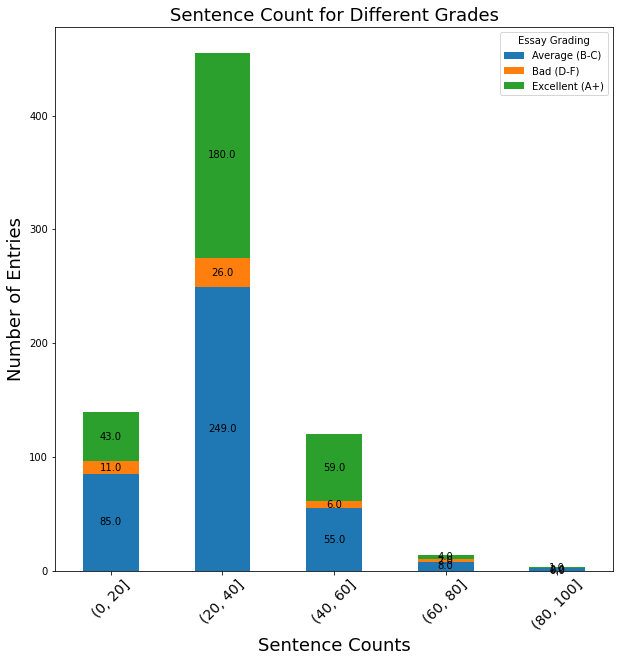

[  41  141  241  341  441  541  641  741  841  941 1041]


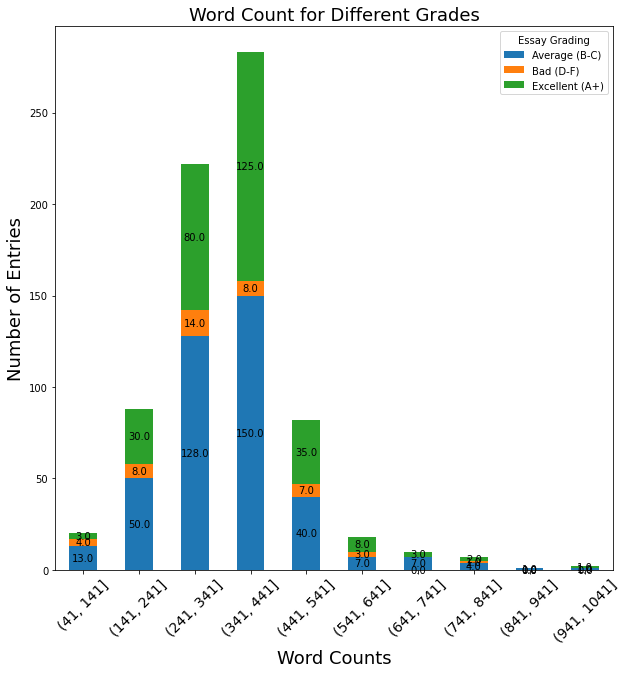

[0.1  0.15 0.2  0.25 0.3 ]


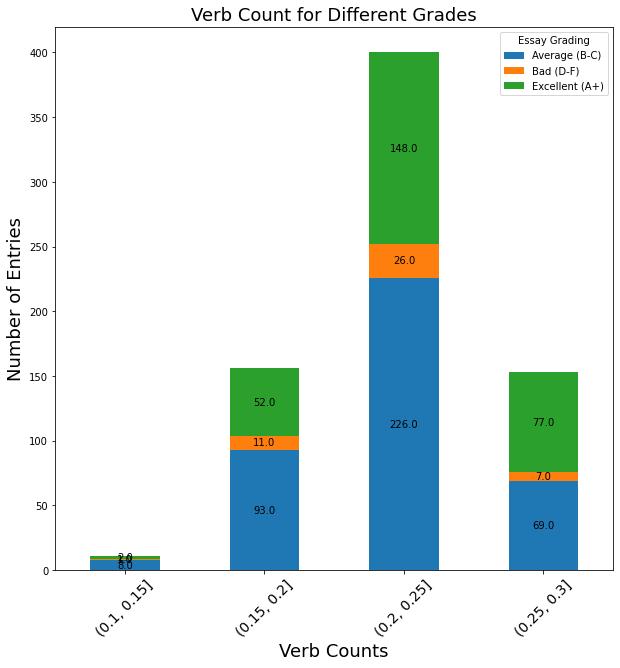

In [35]:
def display_stack_bar(col1,col2,title,xlabel,buffer,binsize):
  bins_created = np.arange(min(df_essays[col1])-buffer, max(df_essays[col1]) + buffer, binsize) 
  print(bins_created)
  df_essays[col2] = pd.cut(df_essays[col1], bins=bins_created)
  df_essays.sort_values(by = col1,inplace=True)
  counts = df_essays.groupby([col2,'Essay Grading'],sort=False).SentenceCount.count().unstack()
  df_essays.drop([col2], axis=1,inplace=True)
  counts.replace(np.nan,0,inplace=True)
  ax = counts.plot.bar(stacked=True,figsize=(10,10),width = 0.5)
  for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            round(height,2), 
            horizontalalignment='center', 
            verticalalignment='center')  
  plt.title(title,fontsize=18)
  plt.xlabel(xlabel,fontsize=18)
  plt.xticks(fontsize=14,rotation=45)
  plt.ylabel('Number of Entries',fontsize=18)
  plt.show()	

display_stack_bar('SentenceCount','SentenceCountCategory','Sentence Count for Different Grades','Sentence Counts',4,20)
display_stack_bar('WordCount','WordCountCategory','Word Count for Different Grades','Word Counts',30,100)
display_stack_bar('VerbCount','VerbCountCategory','Verb Count for Different Grades','Verb Counts',0,.05)
# display_stack_bar('NounCount','NounCountCategory','Noun Count for Different Grades','Noun Counts',10,50)
# display_stack_bar('AdjCount','AdjectivesCountCategory','Adjectives Count for Different Grades','Adjective Counts',5,20)
# display_stack_bar('AdverbCount','AdverbCountCategory','Adverb Count for Different Grades','Adverb Counts',2,10)
# display_stack_bar('PronounCount','PronounCountCategory','Pronoun Count for Different Grades','Pronoun Counts',1,30)
# display_stack_bar('PunctCount','PunctCountCategory','Punctuations Count for Different Grades','Punctuations Counts',10,25)

# **Scatter Plot**

In [36]:
dict  = {2:'Excellent (A+)',1:'Average (B-C)',0:'Bad (D-F)'}
# Split the data into features and target label

df_essays_copy = df_essays.copy()

df_essays_copy['Essay Grading'] = df_essays_copy['Essay Grading'].apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
df_essays_copy.drop(['Essay Text'], axis = 1,inplace=True,errors='ignore')
data = np.asarray(df_essays_copy)

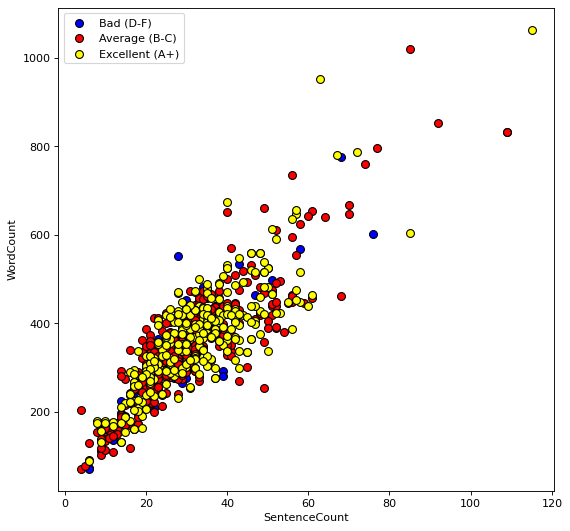

In [37]:
X = data[:,0:2] # SentenceCount WordCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('SentenceCount')
plt.ylabel('WordCount')
plt.legend()
plt.show()

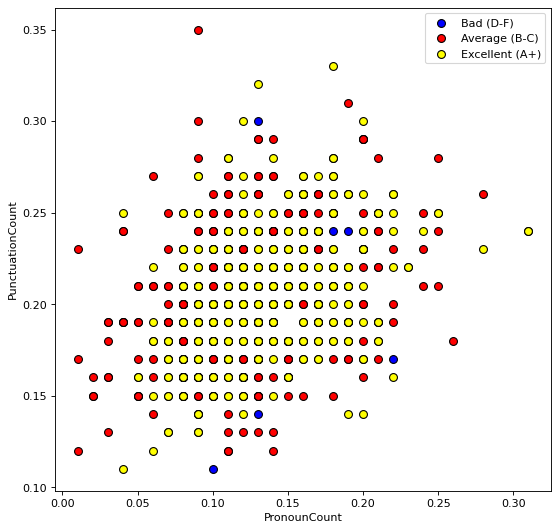

In [38]:
X = data[:,6:8] # PronounCount PunctCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('PronounCount')
plt.ylabel('PunctuationCount')
plt.legend()
plt.show()

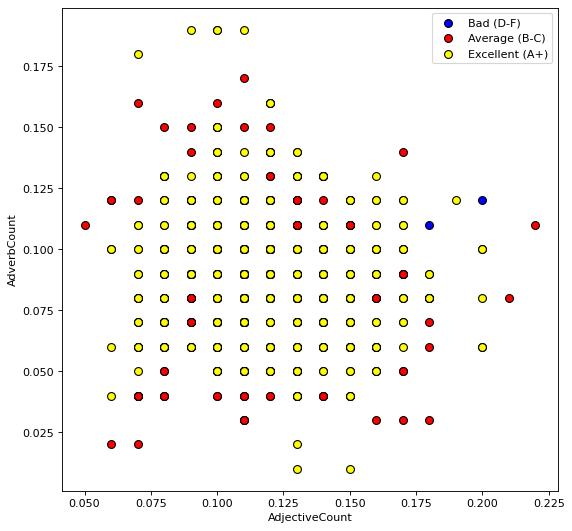

In [39]:
X = data[:,4:6] # Adjective AdverbCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('AdjectiveCount')
plt.ylabel('AdverbCount')
plt.legend()
plt.show()


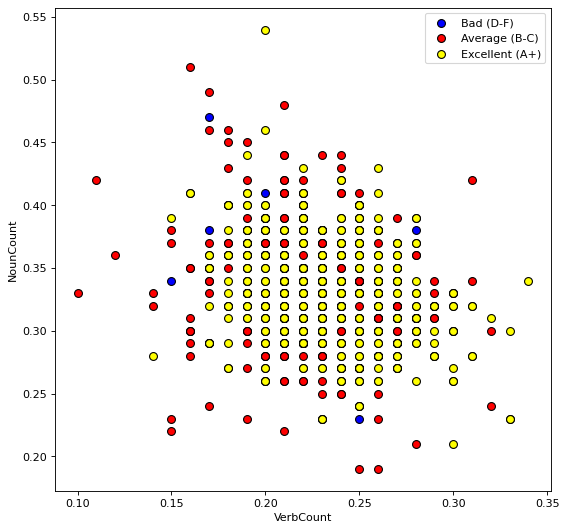

In [40]:
X = data[:,2:4] # VerbCount NounCount
y = data[:,-1]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.xlabel('VerbCount')
plt.ylabel('NounCount')
plt.legend()
plt.show()

# **ROUGH WORK START**

In [41]:
df_essays.replace([np.inf, -np.inf], np.nan, inplace=True)

In [42]:
df_essays.isnull().sum()

Essay Text       0
SentenceCount    0
WordCount        0
VerbCount        0
NounCount        0
AdjCount         0
AdverbCount      0
PronounCount     0
PunctCount       0
Essay Grading    0
dtype: int64

In [43]:
df_essays.dropna(inplace=True)


In [44]:
df_essays.isnull().sum()

Essay Text       0
SentenceCount    0
WordCount        0
VerbCount        0
NounCount        0
AdjCount         0
AdverbCount      0
PronounCount     0
PunctCount       0
Essay Grading    0
dtype: int64

In [45]:
df_essays.head()

,Essay Text,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,Essay Grading
495,The provided line graph depicts the marriages ...,10,133,0.10,0.33,0.12,0.10,0.02,0.15,Average (B-C)
500,The pie chart illustrates the main causes of l...,8,154,0.11,0.42,0.10,0.08,0.01,0.23,Average (B-C)
501,The line graph represented how many units of e...,6,130,0.12,0.36,0.08,0.05,0.02,0.15,Average (B-C)
621,"Throughout my high school career, I have recei...",10,148,0.14,0.32,0.10,0.05,0.12,0.16,Average (B-C)
266,"1 \nEntrepreneur: In 1998, at the age of eight...",32,441,0.14,0.33,0.14,0.07,0.06,0.21,Average (B-C)


# **ROUGH WORK END**

In [47]:
import spacy
import pandas as pd
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

# function to check the type of sentence
def checkForSentType(inputEssay):  
    # running the model on sentence
    doc = nlp(inputEssay)
    sents = list(doc.sents)

    passive_rule = [{'DEP':'nsubjpass'},{'DEP':'aux','OP':'*'},{'DEP':'auxpass'},{'TAG':'VBN'}]
    matcher.add('Passive',None,passive_rule)
    matches = matcher(doc)
    return (len(matches)/len(sents),(len(sents)-len(matches))/len(sents))

df_essays[['NumberofPassiveVoice','NumberofActiveVoice']] = df_essays.apply(lambda row: pd.Series(checkForSentType(row['Essay Text'])),axis=1) 
df_essays.reset_index(drop=True,inplace=True)

In [48]:
def getCountTypeSent(essay_text):
  complex_comp_list=[]
  complex_list=[]
  compound_list=[]
  simple_list=[]
  dep_list = []
  docu = nlp(essay_text)
  num_sent = len([sent for sent in docu.sents]) # Counting the number of sentences

  for sents in docu.sents:
    for token in sents:# Tokenize the sentence into words/tokens
      #subtree argument gives the subtree of the token when parsed in dependency parsing.
      subtree = token.subtree
      #Looking at the ancestors of a token can tell us how deep it is
      k = list(token.ancestors)
      #we need to add this to make the indexing work properly
      k.append('added_to_get_proper_indexing')
      #k=2 gives us the first level of the tree, k=3 will give us the next level.
      if(len(k)==2):
        #print([(t.text) for t in subtree], token.dep_)
        dep_list.append(token.dep_)
      #we missed the root phrase in the previous 
      if(token.dep_=='ROOT'):
        k =[token.text]
      #print(k, 'root')

    #complex sentences have (advcl) in their dependency tree
    #compound sentences have (cc)-> coordination and (conj)-> conjuction in their dependency tree
    #compound complex sentences have both the above
    #simple sentences have neither.
    if ('advcl') in dep_list and ('cc') in dep_list and ('conj') in dep_list:
      complex_comp_list.append('Complex-compound sentence')
    elif ('advcl') in dep_list:
      complex_list.append('Complex sentence')
    elif ('cc') in dep_list and ('conj') in dep_list:
      compound_list.append('Compound sentence')
    else:
      simple_list.append('Simple sentence')
  return (len(complex_comp_list)/num_sent,len(complex_list)/num_sent,len(compound_list)/num_sent,len(simple_list)/num_sent)
  
df_essays[['NumComplexComp','NumComplex','NumCompund','NumSimple']] = df_essays.apply(lambda row: pd.Series(getCountTypeSent(row['Essay Text'])),axis=1) 

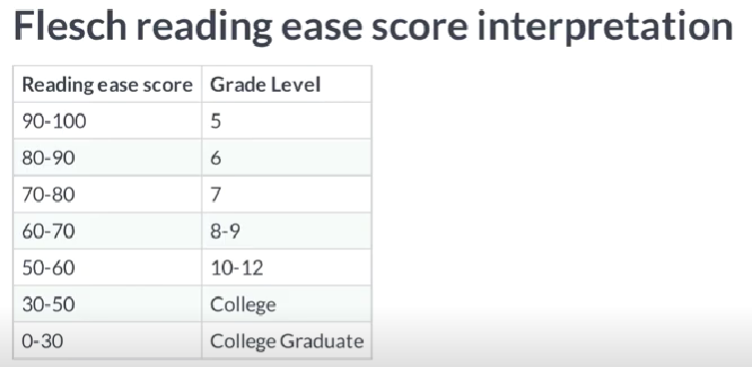

In [49]:
from textatistic import Textatistic
def get_flesch_score(essay_text):
  readability_score = Textatistic(essay_text).scores
  return round(readability_score['flesch_score'],2)

df_essays['FleschScore'] = df_essays.apply(lambda x: get_flesch_score(x['Essay Text']),axis=1) 

In [50]:
df_essays.head(30)

,Essay Text,SentenceCount,WordCount,VerbCount,NounCount,AdjCount,AdverbCount,PronounCount,PunctCount,Essay Grading,NumberofPassiveVoice,NumberofActiveVoice,NumComplexComp,NumComplex,NumCompund,NumSimple,FleschScore
0,The provided line graph depicts the marriages ...,10,133,0.10,0.33,0.12,0.10,0.02,0.15,Average (B-C),0.000000,1.000000,0.100000,0.800000,0.000000,0.100000,74.66
1,The pie chart illustrates the main causes of l...,8,154,0.11,0.42,0.10,0.08,0.01,0.23,Average (B-C),0.000000,1.000000,0.250000,0.125000,0.000000,0.625000,53.25
2,The line graph represented how many units of e...,6,130,0.12,0.36,0.08,0.05,0.02,0.15,Average (B-C),0.166667,0.833333,0.000000,0.666667,0.000000,0.333333,56.16
3,"Throughout my high school career, I have recei...",10,148,0.14,0.32,0.10,0.05,0.12,0.16,Average (B-C),0.200000,0.800000,0.100000,0.000000,0.000000,0.900000,51.76
4,"1 \nEntrepreneur: In 1998, at the age of eight...",32,441,0.14,0.33,0.14,0.07,0.06,0.21,Average (B-C),0.031250,0.968750,0.781250,0.031250,0.000000,0.187500,62.41
5,"I may seem to be a little bit unexpected, a ta...",18,338,0.14,0.28,0.14,0.10,0.09,0.22,Excellent (A+),0.000000,1.000000,0.833333,0.166667,0.000000,0.000000,48.10
6,I first considered applying to Berry College w...,20,303,0.15,0.39,0.13,0.04,0.09,0.25,Excellent (A+),0.000000,1.000000,0.700000,0.000000,0.200000,0.100000,61.84
7,"In the summer of 2000, my family traveled to I...",11,143,0.15,0.22,0.14,0.11,0.06,0.27,Average (B-C),0.090909,0.909091,0.000000,0.090909,0.000000,0.909091,64.20
8,The history of politics reads somewhat like a ...,18,168,0.15,0.34,0.12,0.09,0.10,0.20,Bad (D-F),0.000000,1.000000,0.444444,0.000000,0.111111,0.444444,68.44
9,The give line graph compares the four differen...,9,158,0.15,0.23,0.05,0.11,0.01,0.12,Average (B-C),0.222222,0.777778,0.000000,0.555556,0.000000,0.444444,63.63


In [51]:
# Split the data into features and target label
y = df_essays['Essay Grading']
#X = df_essays.drop(['Essay Grading','Essay Text','SentenceCount','WordCount','VerbCount','NounCount','AdjCount','AdverbCount','PronounCount','PunctCount','NumberofPassiveVoice','NumberofActiveVoice'], axis = 1)
X = df_essays.drop(['Essay Grading','Essay Text'], axis = 1)

y = y.apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)


# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

model = SVC(kernel='sigmoid', gamma=10,random_state = 39,probability=True)
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)
print('F1 score: ', format(f1_score(y_test,y_test_pred,average='micro')))
confusion_matrix(y_test, y_test_pred)

Training set has 587 samples.
Testing set has 147 samples.
The training accuracy is 0.5366269165247018
The test accuracy is 0.5850340136054422
F1 score:  0.5850340136054422


array([[ 0,  8,  0],
       [ 0, 86,  0],
       [ 0, 53,  0]])

In [52]:
# # Split the data into features and target label
# y = df_essays['Essay Grading']
# X = df_essays.drop(['Essay Grading','Essay Text'], axis = 1)

# y = y.apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
# X.head()

In [53]:
# # Import train_test_split
# from sklearn.model_selection import train_test_split

# # Split the 'features' and 'income' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size = 0.3, 
#                                                     random_state = 0)

# # Show the results of the split
# print("Training set has {} samples.".format(X_train.shape[0]))
# print("Testing set has {} samples.".format(X_test.shape[0]))

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

model = SVC(kernel='rbf', gamma=1,random_state = 39,probability=True)
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)
print('F1 score: ', format(f1_score(y_test,y_test_pred,average='micro')))
confusion_matrix(y_test, y_test_pred)

The training accuracy is 0.9829642248722317
The test accuracy is 0.6054421768707483
F1 score:  0.6054421768707483


array([[ 0,  8,  0],
       [ 0, 84,  2],
       [ 0, 48,  5]])

In [55]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score,fbeta_score
# model = SVC(kernel='', gamma=10,random_state = 39,probability=True)
# model.fit(X_train, y_train)
# #results = model.predict_proba(X_test)[0]
# #print(model.predict_proba(X_test)[:, 1])
# predictions_test = model.predict(X_test)


#  #gets a dictionary of {'class_name': probability}
# #prob_per_class_dictionary = dict(zip(model.classes_, results))

# # gets a list of ['most_probable_class', 'second_most_probable_class', ..., 'least_class']
# #results_ordered_by_probability = map(lambda x: x[0], sorted(zip(model.classes_, results), key=lambda x: x[1], reverse=True))
# #print(list(results_ordered_by_probability))
# print(accuracy_score(y_test,predictions_test))
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
predictions = naive_bayes.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test,predictions)))
print('Precision score: ', format(precision_score(y_test,predictions,average='micro')))
print('Recall score: ', format(recall_score(y_test,predictions,average='micro')))
print('F1 score: ', format(f1_score(y_test,predictions,average='micro')))

Accuracy score:  0.5238095238095238
Precision score:  0.5238095238095238
Recall score:  0.5238095238095238
F1 score:  0.5238095238095238


In [ ]:
# from sklearn.linear_model import LogisticRegression

# lr= LogisticRegression(solver='lbfgs', random_state=0,max_iter =1000)
# lr.fit(X_train, y_train)
# y_pred_prob = lr.predict_proba(X_test)
# print(y_pred_prob.shape)
# labels = np.argmax(y_pred_prob, axis=0)
# # print(labels.shape)
# # print(labels)
# # print(lr.classes_)
# # print([y_pred_prob[i] for i in labels])
# y_pred_prob[125]

In [ ]:
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression(solver='lbfgs', random_state=0,max_iter =1000)
lr.fit(X_train, y_train)
y_pred_prob = lr.predict_proba(X_test)
y_pred_prob
# labels = np.argmax(y_pred_prob, axis=0)
classes = lr.classes_
print(classes)
# labels = [classes[i] for i in labels]
# print(accuracy_score(y_test, labels))
# #x = y_pred_prob[0].argmax().item()
# # ix
# #y_pred_prob_test[0][ix]
# # list = []
# # list.append(y_pred_prob_test[0][ix])
# # list.append(f'{y_pred_prob_test[0,ix]:.2%}')
# # list

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='newton-cg', random_state=0,max_iter =10000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test,predictions)))
print('Precision score: ', format(precision_score(y_test,predictions,average='micro')))
print('Recall score: ', format(recall_score(y_test,predictions,average='micro')))
print('F1 score: ', format(f1_score(y_test,predictions,average='micro')))

Accuracy score:  0.5850340136054422
Precision score:  0.5850340136054422
Recall score:  0.5850340136054422
F1 score:  0.5850340136054422


In [63]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# TODO: Define the classifier, and fit it to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.989778534923339
The test accuracy is 0.48299319727891155


In [64]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
BaggingClassifier = BaggingClassifier(n_estimators = 200)
BaggingClassifier.fit(X_train, y_train)
y_train_pred = BaggingClassifier.predict(X_train)
y_test_pred = BaggingClassifier.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)


The training accuracy is 0.989778534923339
The test accuracy is 0.564625850340136


In [65]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

def calculate_F1_Score(parameters):
    # TODO: Make an fbeta_score scoring object.
   # scorer = make_scorer(f1_score)

    # TODO: Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring='f1_macro')

    # TODO: Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(X_train, y_train)

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(X_train)
    best_test_predictions = best_clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, best_train_predictions)
    test_accuracy = accuracy_score(y_test, best_test_predictions)
    print('The training accuracy is', train_accuracy)
    print('The test accuracy is', test_accuracy)
#----------------------------------------------#

# Call the function
calculate_F1_Score(parameters)


The training accuracy is 0.7700170357751278
The test accuracy is 0.5102040816326531


In [ ]:
# df_test = df_essays[:5]
# df_test

In [ ]:
# df_essays.head()
# df_essays[df_essays['Essay Grading']=='Bad (D-F)'].head()

# **Plotting Passive Voice & Active voice against number of sentences**#

In [ ]:
df_essays[df_essays['Essay Grading']=='Average (B-C)']

In [ ]:
dict  = {2:'Excellent (A+)',1:'Average (B-C)',0:'Bad (D-F)'}
# Split the data into features and target label

df_essays_copy = df_essays.copy()

df_essays_copy['Essay Grading'] = df_essays_copy['Essay Grading'].apply(lambda x:2 if x=="Excellent (A+)" else 1 if x=='Average (B-C)' else 0)
df_essays_copy.drop(['Essay Text'], axis = 1,inplace=True,errors='ignore')
data = np.asarray(df_essays_copy)

In [ ]:
X = data[:, [0, 9]] # SentenceCount,NumberofPassiveVoice
y = data[:,-3]

plt.figure(figsize=(18, 18), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.ylabel('Number of Passive Voice Sentences')
plt.xlabel('Number of Sentences')
plt.legend()
plt.show()


In [ ]:
X = data[:, [0, 10]] # SentenceCount,NumberofActiveVoice
y = data[:,-3]

plt.figure(figsize=(18, 18), dpi=80)
plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k',label=dict[0])
plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k',label=dict[1])
plt.scatter(X[np.argwhere(y==2).flatten(),0], X[np.argwhere(y==2).flatten(),1],s = 50, color = 'yellow', edgecolor = 'k',label=dict[2])
plt.ylabel('Number of Active Voice Sentences')
plt.xlabel('Number of Sentences')
plt.legend()
plt.show()


In [ ]:
df_test.head()

In [ ]:
df_essays.tail()

In [ ]:
!pip install textatistic

In [ ]:
X.head

In [ ]:
y.head()